Imports

In [1]:
# 📚 Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

print("Tous les imports sont prêts ")




2025-05-27 16:26:17.074829: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 16:26:17.145832: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 16:26:17.195651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748355977.239048   11031 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748355977.253213   11031 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748355977.364004   11031 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Tous les imports sont prêts 


Objectif : Transformer chaque image pour qu’elle soit uniformisée :

    Niveaux de gris (1 canal)

    Taille fixe (224, 224)

    Pixels normalisés entre 0 et 1

np.expand_dims(img_array, axis=-1) :

    On ajoute une dimension supplémentaire pour indiquer que l’image est en grayscale.

    La forme devient : (224, 224, 1).

In [2]:
def preprocess_image(image_path, size=(224, 224)):
    """
    Prétraitement des images :
    - Convertit en niveaux de gris
    - Redimensionne à 224x224
    - Normalise les pixels entre 0 et 1
    """
    try:
        # Ouvre l'image en niveaux de gris
        img = Image.open(image_path).convert("L")
        
        # Redimensionne à 224x224
        img = img.resize(size)
        
        # Convertit l'image en tableau numpy et normalise
        img_array = np.array(img) / 255.0
        
        # Ajoute une dimension pour le canal (nécessaire pour le CNN)
        img_array = np.expand_dims(img_array, axis=-1)
        
        return img_array
    except Exception as e:
        print(f"Erreur lors du chargement de {image_path}: {e}")
        return None

print("Fonction de prétraitement prête ")

Fonction de prétraitement prête 


In [3]:
def load_dataset(normal_dir, pneumonia_dir, size=(224, 224)):
    images = []
    labels = []

    # Charger NORMAL avec label 0
    for filename in os.listdir(normal_dir):
        if filename.lower().endswith((".jpeg", ".jpg", ".png")):
            path = os.path.join(normal_dir, filename)
            img_array = preprocess_image(path, size)
            if img_array is not None:
                images.append(img_array)
                labels.append(0)

    # Charger PNEUMONIA avec label 1 ou 2 selon virus/bacteria
    for filename in os.listdir(pneumonia_dir):
        if filename.lower().endswith((".jpeg", ".jpg", ".png")):
            label = 1 if "virus" in filename.lower() else 2
            path = os.path.join(pneumonia_dir, filename)
            img_array = preprocess_image(path, size)
            if img_array is not None:
                images.append(img_array)
                labels.append(label)

    return np.array(images), np.array(labels)


Pourquoi cette fonction ?

    Elle va parcourir tous les fichiers dans le dossier.

    Elle utilise preprocess_image() pour transformer chaque image.

    Elle ajoute chaque image à la liste images et son label associé (0 ou 1) à labels.

Pourquoi deux listes ?

    images : contient toutes les images sous forme de matrices numpy (224, 224, 1).

    labels : contient les labels 0 (normal) ou 1 (pneumonia).

In [4]:
# Chemins des dossiers
normal_dir = "chest_Xray/train/NORMAL"
pneumo_dir = "chest_Xray/train/PNEUMONIA"

# Chargement complet des images avec 3 classes : 0 = Normal, 1 = Virus, 2 = Bacteria
X, y = load_dataset(normal_dir, pneumo_dir)

print("Shape de X :", X.shape)
print("Shape de y :", y.shape)
print("Distribution des classes :", np.bincount(y))


Shape de X : (5216, 224, 224, 1)
Shape de y : (5216,)
Distribution des classes : [1341 1345 2530]


In [5]:
# Split des données en 80% train et 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Shape de X_train :", X_train.shape)
print("Shape de X_test :", X_test.shape)
print("Shape de y_train :", y_train.shape)
print("Shape de y_test :", y_test.shape)


Shape de X_train : (4172, 224, 224, 1)
Shape de X_test : (1044, 224, 224, 1)
Shape de y_train : (4172,)
Shape de y_test : (1044,)


normal_images, normal_labels :

    On récupère toutes les images du dossier NORMAL et on leur assigne le label 0.

pneumo_images, pneumo_labels :

    On fait pareil pour le dossier PNEUMONIA, mais avec le label 1.

Fusion des données :

    On combine toutes les images (NORMAL + PNEUMONIA) en un tableau X.

    On combine tous les labels (0 + 1) en un tableau y.

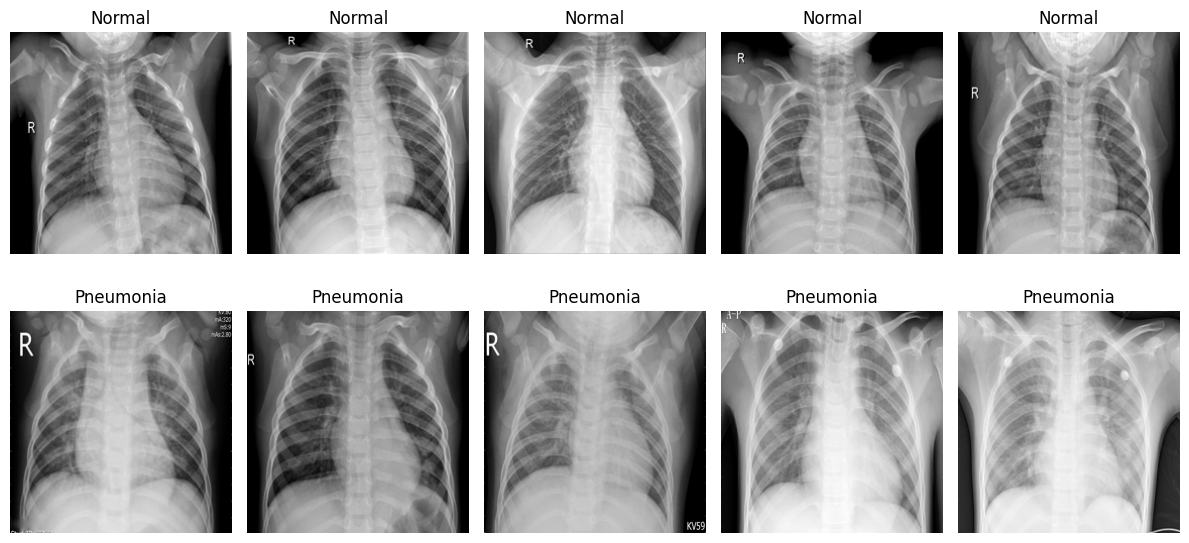

In [6]:
# Indices des images Normal (label 0) et Pneumonia (label 1)
normal_indices = np.where(y == 0)[0]
pneumo_indices = np.where(y == 1)[0]

plt.figure(figsize=(12, 6))

# Afficher 5 images Normal
for i in range(5):
    idx = normal_indices[i]
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[idx].reshape(224, 224), cmap='gray')
    plt.title("Normal")
    plt.axis("off")

# Afficher 5 images Pneumonia
for i in range(5):
    idx = pneumo_indices[i]
    plt.subplot(2, 5, i + 6)
    plt.imshow(X[idx].reshape(224, 224), cmap='gray')
    plt.title("Pneumonia")
    plt.axis("off")

plt.tight_layout()
plt.show()


 FIN DE L'ETL 
 

In [7]:
# Construction du modèle CNN
model = Sequential([
    # Première couche de convolution + pooling
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Deuxième couche de convolution + pooling
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Troisième couche de convolution + pooling
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Aplatissement pour passer en mode linéaire
    Flatten(),
    
    # Couche dense (fully connected)
    Dense(64, activation='relu'),
    
    # Dropout pour éviter l’overfitting (désactive 50% des neurones)
    Dropout(0.5),
    
    # Couche de sortie (softMax) pour classification en 3 classes
    Dense(3, activation='softmax')
])

# Résumé du modèle
model.summary()


/home/uboox/Bureau/projetEpitech/T-DEV-810(AI)/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1748356018.047777   11031 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1748356018.049913   11031 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     5,537,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,630,723 (21.48 MB)

 Trainable params: 5,630,723 (21.48 MB)

 Non-trainable params: 0 (0.00 B)

Conv2D(32, (3, 3)) :

    32 filtres (lunettes) qui vont scanner l’image avec des carrés de 3x3 pixels.

    Chaque filtre cherche des petits motifs (bords, contours).

MaxPooling2D(pool_size=(2, 2)) :

    On prend le maximum d’un carré de 2x2 pixels.

    Ça permet de réduire la taille de l’image tout en gardant l’info essentielle.

Flatten() :

    On transforme le résultat des convolutions en une longue liste de nombres.

    C’est la version aplatie de l’image, mais cette fois avec toutes les features importantes détectées par les convolutions.

Dense(64) :

    64 neurones, chacun connecté à toutes les features de la couche précédente.

    On utilise relu pour éliminer les valeurs négatives.

Dense(1, activation='sigmoid') :

    1 neurone de sortie, car c’est une classification binaire (0 ou 1).

    sigmoid renvoie une probabilité entre 0 et 1.

In [ ]:
# Compilation du modèle
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Modèle compilé")

Modèle compilé ✅


In [9]:

# Data augmentation uniquement pour X_train
datagen = ImageDataGenerator(
    rotation_range=10,         # petites rotations aléatoires
    width_shift_range=0.1,     # décalage horizontal
    height_shift_range=0.1,    # décalage vertical
    zoom_range=0.1,            # zoom léger
    horizontal_flip=True       # retournement horizontal
)

# Applique la transformation au dataset d'entraînement
datagen.fit(X_train)

In [10]:
# S'arreter avant l'overfitting
early_stop = EarlyStopping(
    monitor='val_loss',        # On surveille la perte de validation
    patience=3,                # Attente de 3 epochs sans amélioration
    restore_best_weights=True # On garde les poids du meilleur modèle
)


In [11]:
# Entraînement du modèle
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=11,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/11


/home/uboox/Bureau/projetEpitech/T-DEV-810(AI)/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 89s 667ms/step - accuracy: 0.4503 - loss: 1.1533 - val_accuracy: 0.5718 - val_loss: 0.8996
Epoch 2/11
131/131 ━━━━━━━━━━━━━━━━━━━━ 87s 664ms/step - accuracy: 0.5434 - loss: 0.9409 - val_accuracy: 0.6006 - val_loss: 0.8750
Epoch 3/11
131/131 ━━━━━━━━━━━━━━━━━━━━ 87s 665ms/step - accuracy: 0.5783 - loss: 0.9037 - val_accuracy: 0.6724 - val_loss: 0.6882
Epoch 4/11
131/131 ━━━━━━━━━━━━━━━━━━━━ 87s 664ms/step - accuracy: 0.6199 - loss: 0.8270 - val_accuracy: 0.6561 - val_loss: 0.6919
Epoch 5/11
131/131 ━━━━━━━━━━━━━━━━━━━━ 86s 658ms/step - accuracy: 0.6502 - loss: 0.7980 - val_accuracy: 0.7126 - val_loss: 0.6329
Epoch 6/11
131/131 ━━━━━━━━━━━━━━━━━━━━ 86s 655ms/step - accuracy: 0.6906 - loss: 0.7247 - val_accuracy: 0.7414 - val_loss: 0.6121
Epoch 7/11
131/131 ━━━━━━━━━━━━━━━━━━━━ 86s 657ms/step - accuracy: 0.6892 - loss: 0.7173 - val_accuracy: 0.7375 - val_loss: 0.5958
Epoch 8/11
131/131 ━━━━━━━━━━━━━━━━━━━━ 86s 658ms/step - accuracy: 0.6923 - loss: 0.6930 - val

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

# Prédictions sur le jeu de test
y_pred = np.argmax(model.predict(X_test), axis=1)

# Rapport de classification
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :\n", cm)


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step
              precision    recall  f1-score   support

           0       0.73      0.98      0.84       269
           1       0.68      0.32      0.44       269
           2       0.76      0.84      0.80       506

    accuracy                           0.74      1044
   macro avg       0.72      0.71      0.69      1044
weighted avg       0.73      0.74      0.72      1044

Matrice de confusion :
 [[263   0   6]
 [ 54  87 128]
 [ 41  41 424]]


Roc-AUC


In [13]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import to_categorical

# One-hot encode les vraies classes
y_test_cat = to_categorical(y_test, num_classes=3)

# Prédictions du modèle CNN sous forme de probabilités
y_pred_proba = model.predict(X_test)

# Calcul du score AUC pour multi-classes
roc_auc = roc_auc_score(y_test_cat, y_pred_proba, multi_class='ovo')
print("ROC AUC score (multi-class):", roc_auc)

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step
ROC AUC score (multi-class): 0.8723125681651102


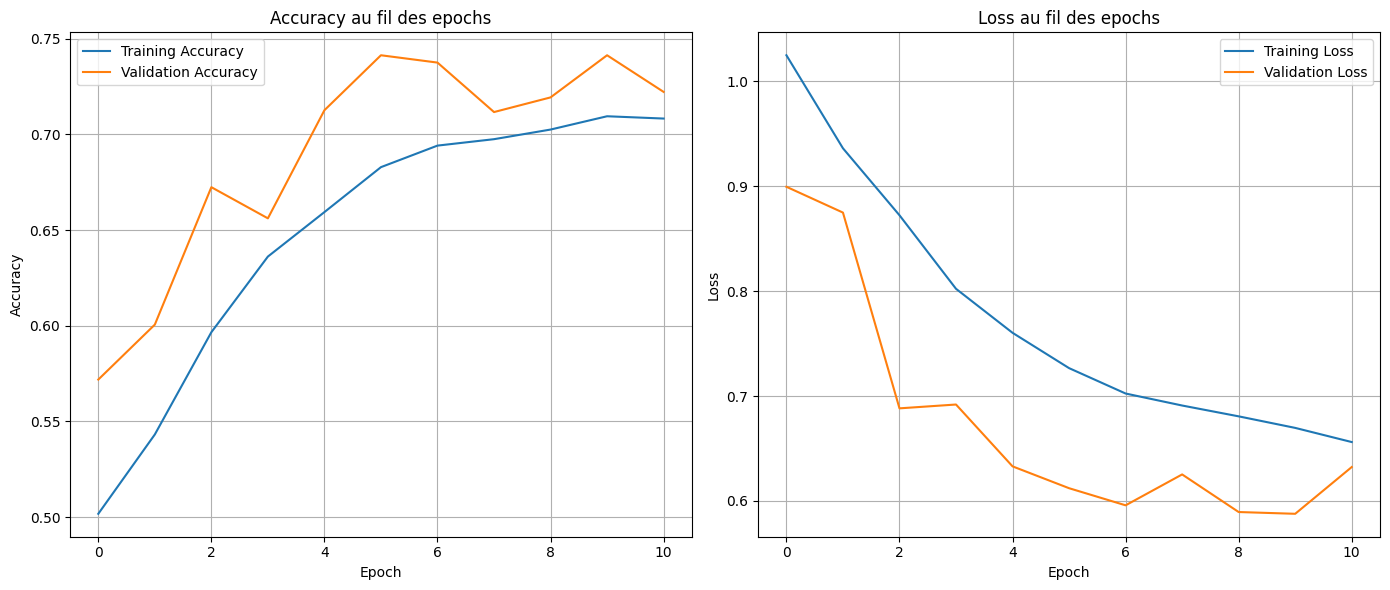

In [14]:
#  Courbes d'entraînement : accuracy et loss
plt.figure(figsize=(14, 6))

# Courbe d'accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy au fil des epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Courbe de loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss au fil des epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Cross validation


In [ ]:
#Cross Validation

# Aplatir les images pour les modèles classiques
X_flat = X.reshape(X.shape[0], -1)

# Modèle simple : régression logistique
clf = LogisticRegression(max_iter=1000)

# Cross-validation à 5 folds
scores = cross_val_score(clf, X_flat, y, cv=5)

print("Scores de cross-validation (logistic regression):", scores)
print("Moyenne des scores :", np.mean(scores))

Comparaison avec un modèle simple (KNN)

In [ ]:


# Modèle KNN
knn = KNeighborsClassifier(n_neighbors=3)
scores_knn = cross_val_score(knn, X_flat, y, cv=5)

print("Scores de cross-validation (KNN):", scores_knn)
print("Moyenne des scores :", np.mean(scores_knn))
